In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling', 
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling', 
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


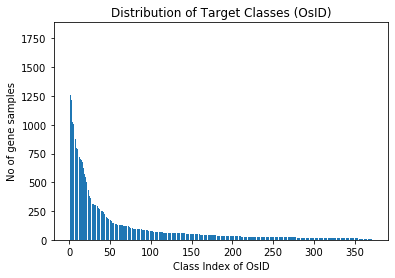

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/140
1846/1846 [==============================] - 6s 2ms/step - loss: 5.1019 - accuracy: 0.0418 - val_loss: 5.0523 - val_accuracy: 0.0315
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9849 - accuracy: 0.0438 - val_loss: 5.0396 - val_accuracy: 0.0436
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9781 - accuracy: 0.0440 - val_loss: 5.0404 - val_accuracy: 0.0436
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.9739 - accuracy: 0.0437 - val_loss: 5.0364 - val_accuracy: 0.0436
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.9707 - accuracy: 0.0440 - val_loss: 5.0450 - val_accuracy: 0.0436
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9675 - accuracy: 0.0440 - val_loss: 5.0338 - val_accuracy: 0.0436
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9642 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0915 - accuracy: 0.0421 - val_loss: 5.0453 - val_accuracy: 0.0436
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.9792 - accuracy: 0.0432 - val_loss: 5.0450 - val_accuracy: 0.0436
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.9691 - accuracy: 0.0437 - val_loss: 5.0329 - val_accuracy: 0.0436
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.9560 - accuracy: 0.0427 - val_loss: 5.0126 - val_accuracy: 0.0436
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9396 - accuracy: 0.0447 - val_loss: 4.9938 - val_accuracy: 0.0444
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.8882 - accuracy: 0.0538 - val_loss: 4.9337 - val_accuracy: 0.0475
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.8377 - accuracy: 0.0529 - val_loss: 4.9089 - val_accuracy: 0.05

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0967 - accuracy: 0.0410 - val_loss: 5.0372 - val_accuracy: 0.0436
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.9689 - accuracy: 0.0463 - val_loss: 5.0040 - val_accuracy: 0.0706
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.8258 - accuracy: 0.0757 - val_loss: 4.8341 - val_accuracy: 0.0706
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.7123 - accuracy: 0.0759 - val_loss: 4.7886 - val_accuracy: 0.0706
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.6743 - accuracy: 0.0779 - val_loss: 4.7421 - val_accuracy: 0.0774
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.6188 - accuracy: 0.0831 - val_loss: 4.6939 - val_accuracy: 0.0774
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.5846 - accuracy: 0.0832 - val_loss: 4.7039 - val_accuracy: 0.07

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0604 - accuracy: 0.0387 - val_loss: 4.9800 - val_accuracy: 0.0436
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.5982 - accuracy: 0.0863 - val_loss: 4.3963 - val_accuracy: 0.1153
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1592 - accuracy: 0.1220 - val_loss: 4.1522 - val_accuracy: 0.1421
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9410 - accuracy: 0.1393 - val_loss: 3.9889 - val_accuracy: 0.1573
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7541 - accuracy: 0.1771 - val_loss: 3.8257 - val_accuracy: 0.1754
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5797 - accuracy: 0.2166 - val_loss: 3.6845 - val_accuracy: 0.2482
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4303 - accuracy: 0.2287 - val_loss: 3.5786 - val_accuracy: 0.22

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0542 - accuracy: 0.0422 - val_loss: 4.9586 - val_accuracy: 0.0315
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.6271 - accuracy: 0.0733 - val_loss: 4.3638 - val_accuracy: 0.1175
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.0501 - accuracy: 0.1500 - val_loss: 3.9851 - val_accuracy: 0.1685
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6504 - accuracy: 0.2000 - val_loss: 3.6142 - val_accuracy: 0.2057
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2314 - accuracy: 0.2657 - val_loss: 3.2458 - val_accuracy: 0.3061
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8738 - accuracy: 0.3220 - val_loss: 2.9428 - val_accuracy: 0.3140
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5786 - accuracy: 0.3672 - val_loss: 2.7770 - val_accuracy: 0.36

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.9857 - accuracy: 0.0505 - val_loss: 4.6517 - val_accuracy: 0.0803
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.2301 - accuracy: 0.1219 - val_loss: 4.0506 - val_accuracy: 0.1760
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5186 - accuracy: 0.2654 - val_loss: 3.3298 - val_accuracy: 0.3045
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.8879 - accuracy: 0.3561 - val_loss: 2.8731 - val_accuracy: 0.4084
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4666 - accuracy: 0.4457 - val_loss: 2.5385 - val_accuracy: 0.4838
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.1175 - accuracy: 0.5107 - val_loss: 2.2866 - val_accuracy: 0.5465
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8430 - accuracy: 0.5642 - val_loss: 2.0825 - val_accuracy: 0.58

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0276 - accuracy: 0.0468 - val_loss: 4.8708 - val_accuracy: 0.0480
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.5360 - accuracy: 0.0897 - val_loss: 4.4132 - val_accuracy: 0.1241
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.0901 - accuracy: 0.1604 - val_loss: 3.9851 - val_accuracy: 0.1727
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6845 - accuracy: 0.2065 - val_loss: 3.6500 - val_accuracy: 0.2530
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2679 - accuracy: 0.2762 - val_loss: 3.1734 - val_accuracy: 0.3531
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8060 - accuracy: 0.3523 - val_loss: 2.8223 - val_accuracy: 0.4048
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4382 - accuracy: 0.4263 - val_loss: 2.5767 - val_accuracy: 0.41

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7789 - accuracy: 0.0500 - val_loss: 4.5480 - val_accuracy: 0.0741
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.3451 - accuracy: 0.0733 - val_loss: 4.3055 - val_accuracy: 0.0796
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0565 - accuracy: 0.1064 - val_loss: 3.9946 - val_accuracy: 0.1318
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7287 - accuracy: 0.1771 - val_loss: 3.6678 - val_accuracy: 0.2337
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3383 - accuracy: 0.2467 - val_loss: 3.2573 - val_accuracy: 0.2409
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9476 - accuracy: 0.2990 - val_loss: 2.8977 - val_accuracy: 0.3245
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5913 - accuracy: 0.3718 - val_loss: 2.6129 - val_accuracy: 0.40

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7631 - accuracy: 0.0453 - val_loss: 4.5050 - val_accuracy: 0.0741
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2679 - accuracy: 0.0838 - val_loss: 4.1704 - val_accuracy: 0.1171
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7843 - accuracy: 0.1779 - val_loss: 3.5181 - val_accuracy: 0.2392
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1042 - accuracy: 0.3116 - val_loss: 3.0026 - val_accuracy: 0.3393
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6131 - accuracy: 0.3943 - val_loss: 2.6688 - val_accuracy: 0.3905
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2804 - accuracy: 0.4492 - val_loss: 2.3427 - val_accuracy: 0.4491
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0450 - accuracy: 0.4945 - val_loss: 2.1265 - val_accuracy: 0.51

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7901 - accuracy: 0.0488 - val_loss: 4.5549 - val_accuracy: 0.0834
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.3424 - accuracy: 0.0883 - val_loss: 4.3091 - val_accuracy: 0.1003
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0525 - accuracy: 0.1107 - val_loss: 4.0203 - val_accuracy: 0.1197
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7508 - accuracy: 0.1446 - val_loss: 3.7449 - val_accuracy: 0.1518
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4967 - accuracy: 0.1688 - val_loss: 3.5295 - val_accuracy: 0.1778
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2450 - accuracy: 0.2096 - val_loss: 3.2600 - val_accuracy: 0.2249
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0208 - accuracy: 0.2477 - val_loss: 3.0534 - val_accuracy: 0.26

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 4.7355 - accuracy: 0.0530 - val_loss: 4.4969 - val_accuracy: 0.0673
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1788 - accuracy: 0.1006 - val_loss: 4.0441 - val_accuracy: 0.1382
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7879 - accuracy: 0.1359 - val_loss: 3.7306 - val_accuracy: 0.1472
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4900 - accuracy: 0.1827 - val_loss: 3.5186 - val_accuracy: 0.2055
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2300 - accuracy: 0.2213 - val_loss: 3.2545 - val_accuracy: 0.2469
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9848 - accuracy: 0.2621 - val_loss: 3.0523 - val_accuracy: 0.2845
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7583 - accuracy: 0.2977 - val_loss: 2.8658 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.7740 - accuracy: 0.0532 - val_loss: 4.5002 - val_accuracy: 0.0724
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2347 - accuracy: 0.1019 - val_loss: 4.1221 - val_accuracy: 0.1021
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8971 - accuracy: 0.1300 - val_loss: 3.9185 - val_accuracy: 0.1164
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6589 - accuracy: 0.1530 - val_loss: 3.6631 - val_accuracy: 0.1633
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4646 - accuracy: 0.1787 - val_loss: 3.5214 - val_accuracy: 0.1703
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2978 - accuracy: 0.2073 - val_loss: 3.3688 - val_accuracy: 0.2114
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1338 - accuracy: 0.2285 - val_loss: 3.2113 - val_accuracy: 0.26

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 4.7748 - accuracy: 0.0545 - val_loss: 4.5281 - val_accuracy: 0.0671
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2052 - accuracy: 0.1039 - val_loss: 4.0470 - val_accuracy: 0.1217
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7968 - accuracy: 0.1459 - val_loss: 3.7450 - val_accuracy: 0.1474
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5341 - accuracy: 0.1758 - val_loss: 3.5217 - val_accuracy: 0.1949
Epoch 5/140
1846/1846 [==============================] - 5s 2ms/step - loss: 3.2648 - accuracy: 0.2153 - val_loss: 3.2686 - val_accuracy: 0.2350
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9941 - accuracy: 0.2660 - val_loss: 3.0363 - val_accuracy: 0.2735
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6982 - accuracy: 0.3320 - val_loss: 2.7625 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8029 - accuracy: 0.0532 - val_loss: 4.5393 - val_accuracy: 0.0733
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1805 - accuracy: 0.1134 - val_loss: 4.0185 - val_accuracy: 0.1259
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7732 - accuracy: 0.1435 - val_loss: 3.7321 - val_accuracy: 0.1584
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5226 - accuracy: 0.1714 - val_loss: 3.5339 - val_accuracy: 0.1881
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3066 - accuracy: 0.2049 - val_loss: 3.3470 - val_accuracy: 0.2205
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0881 - accuracy: 0.2420 - val_loss: 3.1676 - val_accuracy: 0.2286
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8252 - accuracy: 0.3019 - val_loss: 2.9104 - val_accuracy: 0.33

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7838 - accuracy: 0.0525 - val_loss: 4.4812 - val_accuracy: 0.0799
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1045 - accuracy: 0.1164 - val_loss: 3.9648 - val_accuracy: 0.1265
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7069 - accuracy: 0.1571 - val_loss: 3.7247 - val_accuracy: 0.1604
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4490 - accuracy: 0.1839 - val_loss: 3.4641 - val_accuracy: 0.1936
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2287 - accuracy: 0.2212 - val_loss: 3.2985 - val_accuracy: 0.2304
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0327 - accuracy: 0.2532 - val_loss: 3.1365 - val_accuracy: 0.2484
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8292 - accuracy: 0.2876 - val_loss: 2.9554 - val_accuracy: 0.27

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8104 - accuracy: 0.0584 - val_loss: 4.5033 - val_accuracy: 0.1061
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.1298 - accuracy: 0.1188 - val_loss: 3.9514 - val_accuracy: 0.1347
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6706 - accuracy: 0.1658 - val_loss: 3.6559 - val_accuracy: 0.1793
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3283 - accuracy: 0.2110 - val_loss: 3.3325 - val_accuracy: 0.2114
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0092 - accuracy: 0.2653 - val_loss: 3.0456 - val_accuracy: 0.2794
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7137 - accuracy: 0.3088 - val_loss: 2.8101 - val_accuracy: 0.3325
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4547 - accuracy: 0.3648 - val_loss: 2.5843 - val_accuracy: 0.39

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8114 - accuracy: 0.0600 - val_loss: 4.4980 - val_accuracy: 0.1010
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0956 - accuracy: 0.1268 - val_loss: 3.9288 - val_accuracy: 0.1364
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6454 - accuracy: 0.1798 - val_loss: 3.6230 - val_accuracy: 0.1771
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3308 - accuracy: 0.2181 - val_loss: 3.3482 - val_accuracy: 0.2334
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0289 - accuracy: 0.2748 - val_loss: 3.0631 - val_accuracy: 0.3100
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7286 - accuracy: 0.3414 - val_loss: 2.8440 - val_accuracy: 0.3584
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4563 - accuracy: 0.3949 - val_loss: 2.5847 - val_accuracy: 0.43

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8381 - accuracy: 0.0625 - val_loss: 4.4479 - val_accuracy: 0.1023
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0367 - accuracy: 0.1379 - val_loss: 3.8674 - val_accuracy: 0.1633
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5934 - accuracy: 0.1861 - val_loss: 3.5326 - val_accuracy: 0.1868
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2144 - accuracy: 0.2438 - val_loss: 3.1629 - val_accuracy: 0.2898
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8113 - accuracy: 0.3271 - val_loss: 2.8137 - val_accuracy: 0.3344
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4698 - accuracy: 0.4005 - val_loss: 2.5166 - val_accuracy: 0.4266
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2019 - accuracy: 0.4694 - val_loss: 2.2954 - val_accuracy: 0.47

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8826 - accuracy: 0.0567 - val_loss: 4.5354 - val_accuracy: 0.0761
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1245 - accuracy: 0.1216 - val_loss: 3.9826 - val_accuracy: 0.1520
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7039 - accuracy: 0.1730 - val_loss: 3.6655 - val_accuracy: 0.1712
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.4055 - accuracy: 0.2080 - val_loss: 3.4110 - val_accuracy: 0.2152
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1310 - accuracy: 0.2555 - val_loss: 3.1961 - val_accuracy: 0.2627
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8791 - accuracy: 0.2977 - val_loss: 2.9688 - val_accuracy: 0.3127
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6428 - accuracy: 0.3590 - val_loss: 2.7717 - val_accuracy: 0.36

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8700 - accuracy: 0.0571 - val_loss: 4.5576 - val_accuracy: 0.0693
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.1448 - accuracy: 0.1294 - val_loss: 3.9617 - val_accuracy: 0.1347
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6643 - accuracy: 0.1859 - val_loss: 3.6131 - val_accuracy: 0.1945
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3260 - accuracy: 0.2239 - val_loss: 3.3172 - val_accuracy: 0.2532
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9996 - accuracy: 0.2791 - val_loss: 3.0346 - val_accuracy: 0.3208
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6850 - accuracy: 0.3439 - val_loss: 2.7314 - val_accuracy: 0.3718
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4140 - accuracy: 0.4040 - val_loss: 2.5541 - val_accuracy: 0.43

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

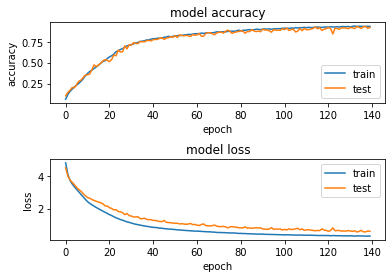

Final Test Accuracy: 0.9394118189811707


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.94      1.00      0.97       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       0.99      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       0.97      1.00      0.98       237
          14       0.93      1.00      0.96       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os03g0719800         328              328        True
1  Os01g0741900         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.045
1,2,0.075
2,3,0.090
3,4,0.457
4,5,0.720
5,6,0.880
6,7,0.859
7,8,0.870
8,9,0.919
9,10,0.925
